In [205]:
# Import libraries
import numpy as np
import nmrformd as nmrmd
import MDAnalysis as mda
from scipy.special import sph_harm

recalculate=False

# For figure plotting
import sys
from matplotlib import pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
msize = 5
fontsize = 30
font = {'family': 'sans', 'color':  'black', 'weight': 'normal', 'size': fontsize}
myblue_light = [42/ 255, 99/255, 255/ 255] # [0/ 255, 150/255, 177/ 255]
myblue_dark = [43/ 255, 140/255, 238/ 255] # [0/ 255, 150/255, 177/ 255]
myred= [244/ 255, 143/255, 97/ 255] # [255/ 255, 77/255, 77/ 255]
mygreen = [122/255, 190/255, 165/255]
lightgray = [0.1, 0.1, 0.1]
darkgray = [0.9, 0.9, 0.9]
white = [0, 0, 0]
black = [1, 1, 1]
sys.path.append('../../shared/')
from tools import figure_improvement, save_figure

# Path to data
datapath_300 = "../../raw-data/bulk-water/N3000-short-T300/"
datapath_275 = "../../raw-data/bulk-water/N3000-short-T275/"

alpha_m = [np.sqrt(16 * np.pi / 5), np.sqrt(8 * np.pi / 15), np.sqrt(32 * np.pi / 15)]

In [206]:
type_analysis = "intra_molecular"
isotropic = True
isotropic 
if isotropic:
    dim = 1
else:
    dim = 3
    
if recalculate:
    # Create a MDAnalysis universe
    for datapath in [datapath_300]:
        u = mda.Universe(datapath+"run.tpr", datapath+"run.xtc")

        # groups
        group_i = u.select_atoms("type HW")
        neighbor_j = group_i

        index_i = np.array(group_i.atoms.indices)
        
        for cpt_i in [100]: #, 10, 20]:
            group_i = u.select_atoms('index ' + str(index_i[cpt_i]))
            resids_i = group_i.resids[group_i.atoms.indices == index_i[cpt_i]]

            if type_analysis == "intra_molecular":
                same_residue : bool = neighbor_j.resids == resids_i
                different_atom : bool = neighbor_j.indices != index_i[cpt_i]
                index_j = neighbor_j.atoms.indices[same_residue & different_atom]
                str_j = ' '.join(str(e) for e in index_j)
            elif type_analysis == "inter_molecular":
                different_residue : bool = neighbor_j.resids != resids_i
                index_j = neighbor_j.atoms.indices[different_residue]
                str_j = ' '.join(str(e) for e in index_j)
            elif type_analysis == "full":
                different_atom : bool = neighbor_j.indices != index_i[cpt_i]
                index_j = neighbor_j.atoms.indices[different_atom]
                str_j = ' '.join(str(e) for e in index_j)
            if len(str_j) == 0:
                raise ValueError("Empty atom groups j \n"
                                    "Wrong combination of type_analysis and group selection?")
            else:
                group_j = u.select_atoms('index ' + str_j)

            if isotropic:
                data = np.zeros((dim, u.trajectory.n_frames, group_j.atoms.n_atoms), dtype=np.float16)
                rij_data = np.zeros((dim, u.trajectory.n_frames, group_j.atoms.n_atoms), dtype=np.float16)
                theta_data = np.zeros((dim, u.trajectory.n_frames, group_j.atoms.n_atoms), dtype=np.float16)
            else:
                data = np.zeros((dim, u.trajectory.n_frames, group_j.atoms.n_atoms), dtype=np.complex64)
                rij_data = np.zeros((dim, u.trajectory.n_frames, group_j.atoms.n_atoms), dtype=np.complex64)
                theta_data = np.zeros((dim, u.trajectory.n_frames, group_j.atoms.n_atoms), dtype=np.complex64)
            gij = np.zeros((dim,  u.trajectory.n_frames), dtype=np.float32)
            timestep = np.round(u.trajectory.dt, 4)
            t = np.arange(u.trajectory.n_frames) * timestep

            for cpt, ts in enumerate(u.trajectory):
                position_i = group_i.atoms.positions
                position_j = group_j.atoms.positions
                box = ts.dimensions
                # ensure that the box is orthonormal
                rij = (np.remainder(position_i - position_j + box[:3]/2., box[:3]) - box[:3]/2.).T
                r = np.sqrt(rij[0]**2 + rij[1]**2 + rij[2]**2)
                theta = np.arctan2(np.sqrt(rij[0]**2 + rij[1]**2), rij[2])
                phi = np.arctan2(rij[1], rij[0])
                F_val = []
                for m in range(dim):
                    F_val.append(alpha_m[m] * sph_harm(m, 2, phi, theta) / np.power(r, 3))
                if isotropic:
                    F_val[0] = F_val[0].real
                sph_val = F_val
                data[:, cpt] = sph_val
                F_val = []
                for m in range(dim):
                    F_val.append(r)
                if isotropic:
                    F_val[0] = F_val[0].real
                sph_val = F_val
                rij_data[:, cpt] = sph_val
                F_val = []
                for m in range(dim):
                    F_val.append(theta)
                if isotropic:
                    F_val[0] = F_val[0].real
                sph_val = F_val
                theta_data[:, cpt] = sph_val

    data_intramolecular = np.vstack([t, data[0].T, rij_data[0].T, theta_data[0].T])
    np.savetxt("../../treated-data/best-practice/bulk-water/intramolecular-signal-illustration.dat", data_intramolecular.T)
else:
    data_intramolecular = np.loadtxt("../../treated-data/best-practice/bulk-water/intramolecular-signal-illustration.dat").T

In [207]:
type_analysis = "inter_molecular"
isotropic = True
isotropic 
if isotropic:
    dim = 1
else:
    dim = 3

if recalculate:
    # Create a MDAnalysis universe
    for datapath in [datapath_300]:
        u = mda.Universe(datapath+"run.tpr", datapath+"run.xtc")

        # groups
        group_i = u.select_atoms("type HW")
        neighbor_j = group_i

        index_i = np.array(group_i.atoms.indices)
        
        for cpt_i in [100]: #, 10, 20]:
            group_i = u.select_atoms('index ' + str(index_i[cpt_i]))
            resids_i = group_i.resids[group_i.atoms.indices == index_i[cpt_i]]

            if type_analysis == "intra_molecular":
                same_residue : bool = neighbor_j.resids == resids_i
                different_atom : bool = neighbor_j.indices != index_i[cpt_i]
                index_j = neighbor_j.atoms.indices[same_residue & different_atom]
                str_j = ' '.join(str(e) for e in index_j)
            elif type_analysis == "inter_molecular":
                different_residue : bool = neighbor_j.resids != resids_i
                index_j = neighbor_j.atoms.indices[different_residue]
                str_j = ' '.join(str(e) for e in index_j)
            elif type_analysis == "full":
                different_atom : bool = neighbor_j.indices != index_i[cpt_i]
                index_j = neighbor_j.atoms.indices[different_atom]
                str_j = ' '.join(str(e) for e in index_j)
            if len(str_j) == 0:
                raise ValueError("Empty atom groups j \n"
                                    "Wrong combination of type_analysis and group selection?")
            else:
                group_j = u.select_atoms('index ' + str_j)

            if isotropic:
                data = np.zeros((dim, u.trajectory.n_frames, group_j.atoms.n_atoms), dtype=np.float16)
                rij_data = np.zeros((dim, u.trajectory.n_frames, group_j.atoms.n_atoms), dtype=np.float16)
                theta_data = np.zeros((dim, u.trajectory.n_frames, group_j.atoms.n_atoms), dtype=np.float16)
            else:
                data = np.zeros((dim, u.trajectory.n_frames, group_j.atoms.n_atoms), dtype=np.complex64)
                rij_data = np.zeros((dim, u.trajectory.n_frames, group_j.atoms.n_atoms), dtype=np.complex64)
                theta_data = np.zeros((dim, u.trajectory.n_frames, group_j.atoms.n_atoms), dtype=np.complex64)
            gij = np.zeros((dim,  u.trajectory.n_frames), dtype=np.float32)
            timestep = np.round(u.trajectory.dt, 4)
            t = np.arange(u.trajectory.n_frames) * timestep

            for cpt, ts in enumerate(u.trajectory):
                position_i = group_i.atoms.positions
                position_j = group_j.atoms.positions
                box = ts.dimensions
                # ensure that the box is orthonormal
                rij = (np.remainder(position_i - position_j + box[:3]/2., box[:3]) - box[:3]/2.).T
                r = np.sqrt(rij[0]**2 + rij[1]**2 + rij[2]**2)
                theta = np.arctan2(np.sqrt(rij[0]**2 + rij[1]**2), rij[2])
                phi = np.arctan2(rij[1], rij[0])
                F_val = []
                for m in range(dim):
                    F_val.append(alpha_m[m] * sph_harm(m, 2, phi, theta) / np.power(r, 3))
                if isotropic:
                    F_val[0] = F_val[0].real
                sph_val = F_val
                data[:, cpt] = sph_val
                F_val = []
                for m in range(dim):
                    F_val.append(r)
                if isotropic:
                    F_val[0] = F_val[0].real
                sph_val = F_val
                rij_data[:, cpt] = sph_val
                F_val = []
                for m in range(dim):
                    F_val.append(theta)
                if isotropic:
                    F_val[0] = F_val[0].real
                sph_val = F_val
                theta_data[:, cpt] = sph_val

    n = np.where(np.min(rij_data[0][300]) == rij_data[0][300])[0][0]
    data_intermolecular = np.vstack([t, data[0].T[n], rij_data[0].T[n], theta_data[0].T[n]])
    np.savetxt("../../treated-data/best-practice/bulk-water/intermolecular-signal-illustration.dat", data_intermolecular.T)
else:
    data_intermolecular = np.loadtxt("../../treated-data/best-practice/bulk-water/intermolecular-signal-illustration.dat").T

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


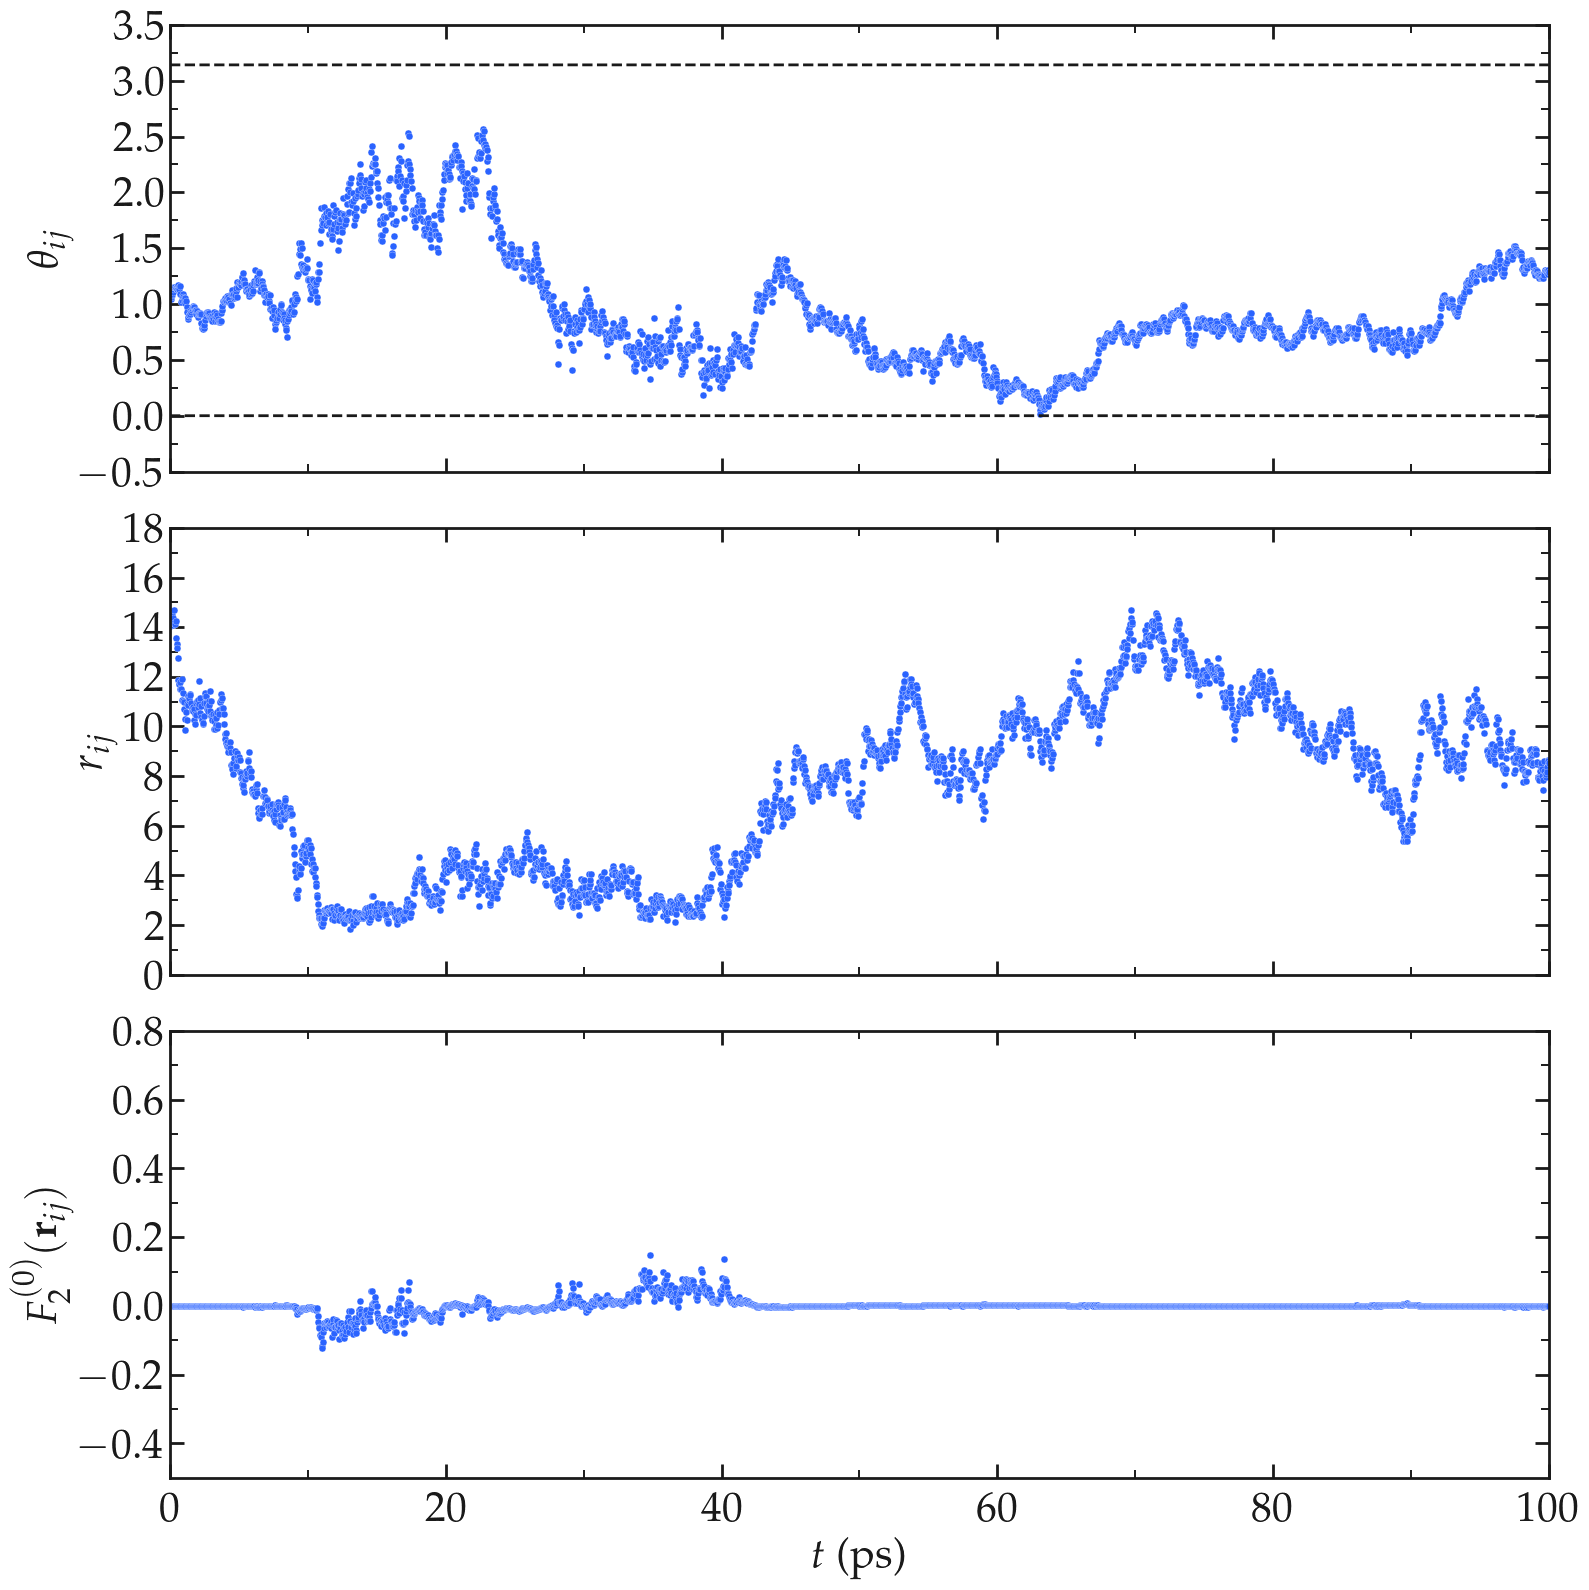

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


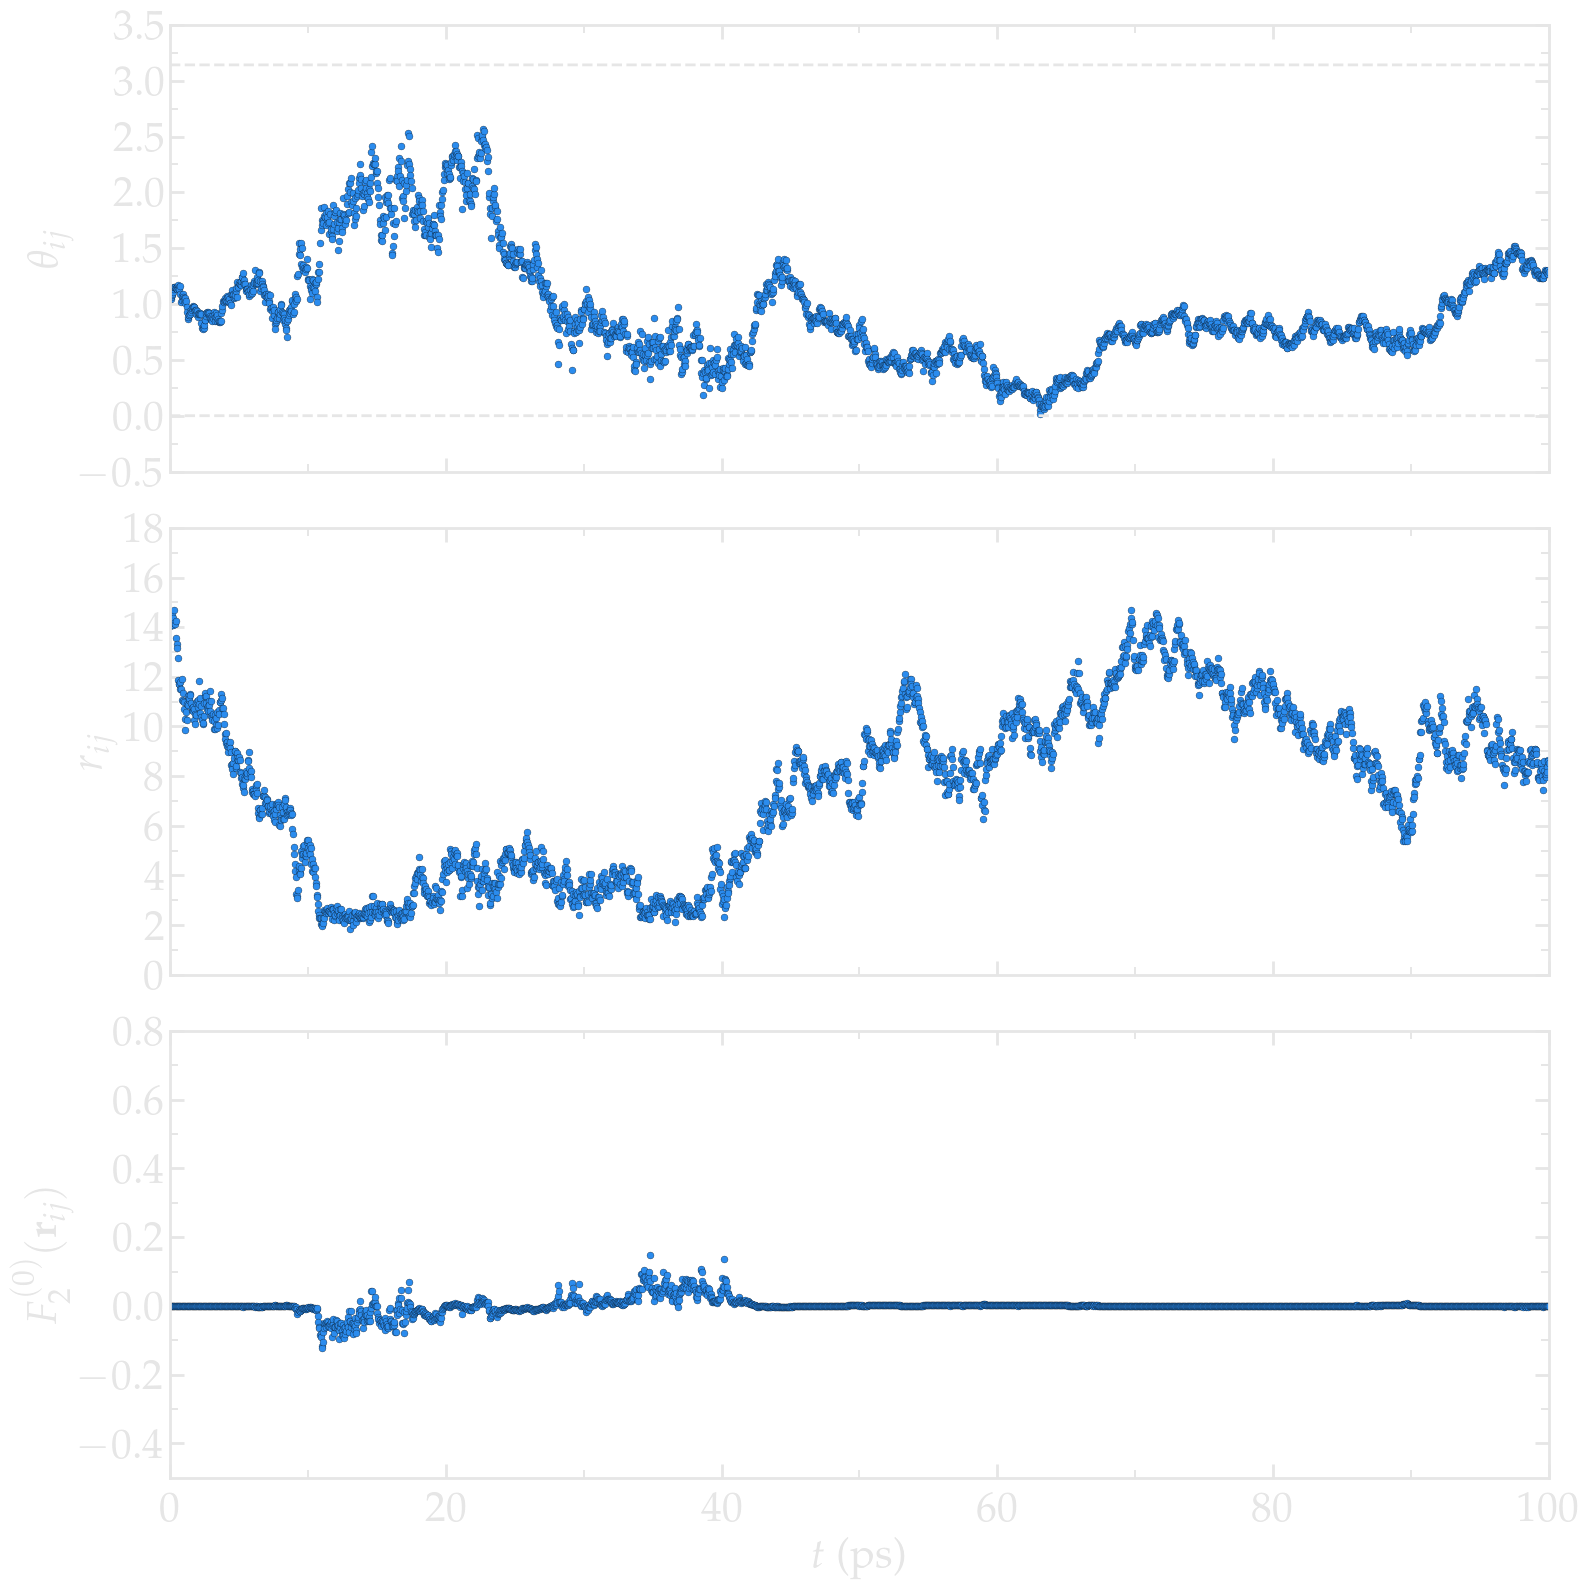

In [208]:
# T1 bulk water
for mode, mygray, edge, myblue in zip(['light', 'dark'], [lightgray, darkgray], [black, white], [myblue_light, myblue_dark]):
    fig = plt.figure(figsize=(16, 16))

    ax1 = fig.add_subplot(311)
    ax1.plot(data_intermolecular[0], data_intermolecular[3], 'o', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=myblue)
    ax1.plot(data_intermolecular[0], data_intermolecular[3]*0, '--', linewidth = 2, color=mygray)
    ax1.plot(data_intermolecular[0], data_intermolecular[3]*0 + np.pi, '--', linewidth = 2, color=mygray)
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=None, ylabel=r'$\theta_{ij}$',
                       xlim=(0, 100), ylim=(-0.5, 3.5), cut_x=2, cut_y=2)

    ax1 = fig.add_subplot(312)
    ax1.plot(data_intermolecular[0], data_intermolecular[2], 'o', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=myblue)
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=None, ylabel=r'$r_{ij}$',
                       xlim=(0, 100), ylim=(0, 18), cut_x=2, cut_y=2)
    
    ax1 = fig.add_subplot(313)
    ax1.plot(data_intermolecular[0], data_intermolecular[1], 'o', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=myblue)
    #ax1.plot(data_intermolecular[0], data_intermolecular[3]*0 + (3 * np.cos(0)**2 - 1), '--', linewidth = 2, color=mygray)
    #ax1.plot(data_intermolecular[0], data_intermolecular[3]*0 + (3 * np.cos(np.pi/2)**2 - 1) , '--', linewidth = 2, color=mygray)
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r"$t$ (ps)", ylabel=r'$F_2^{(0)} (\textbf{r}_{ij})$',
                       xlim=(0, 100), ylim=(-0.5, 0.8), cut_x=2, cut_y=2)
    save_figure(plt, fig, mode, name='best-practices/intermolecular-signal-illustration', save=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


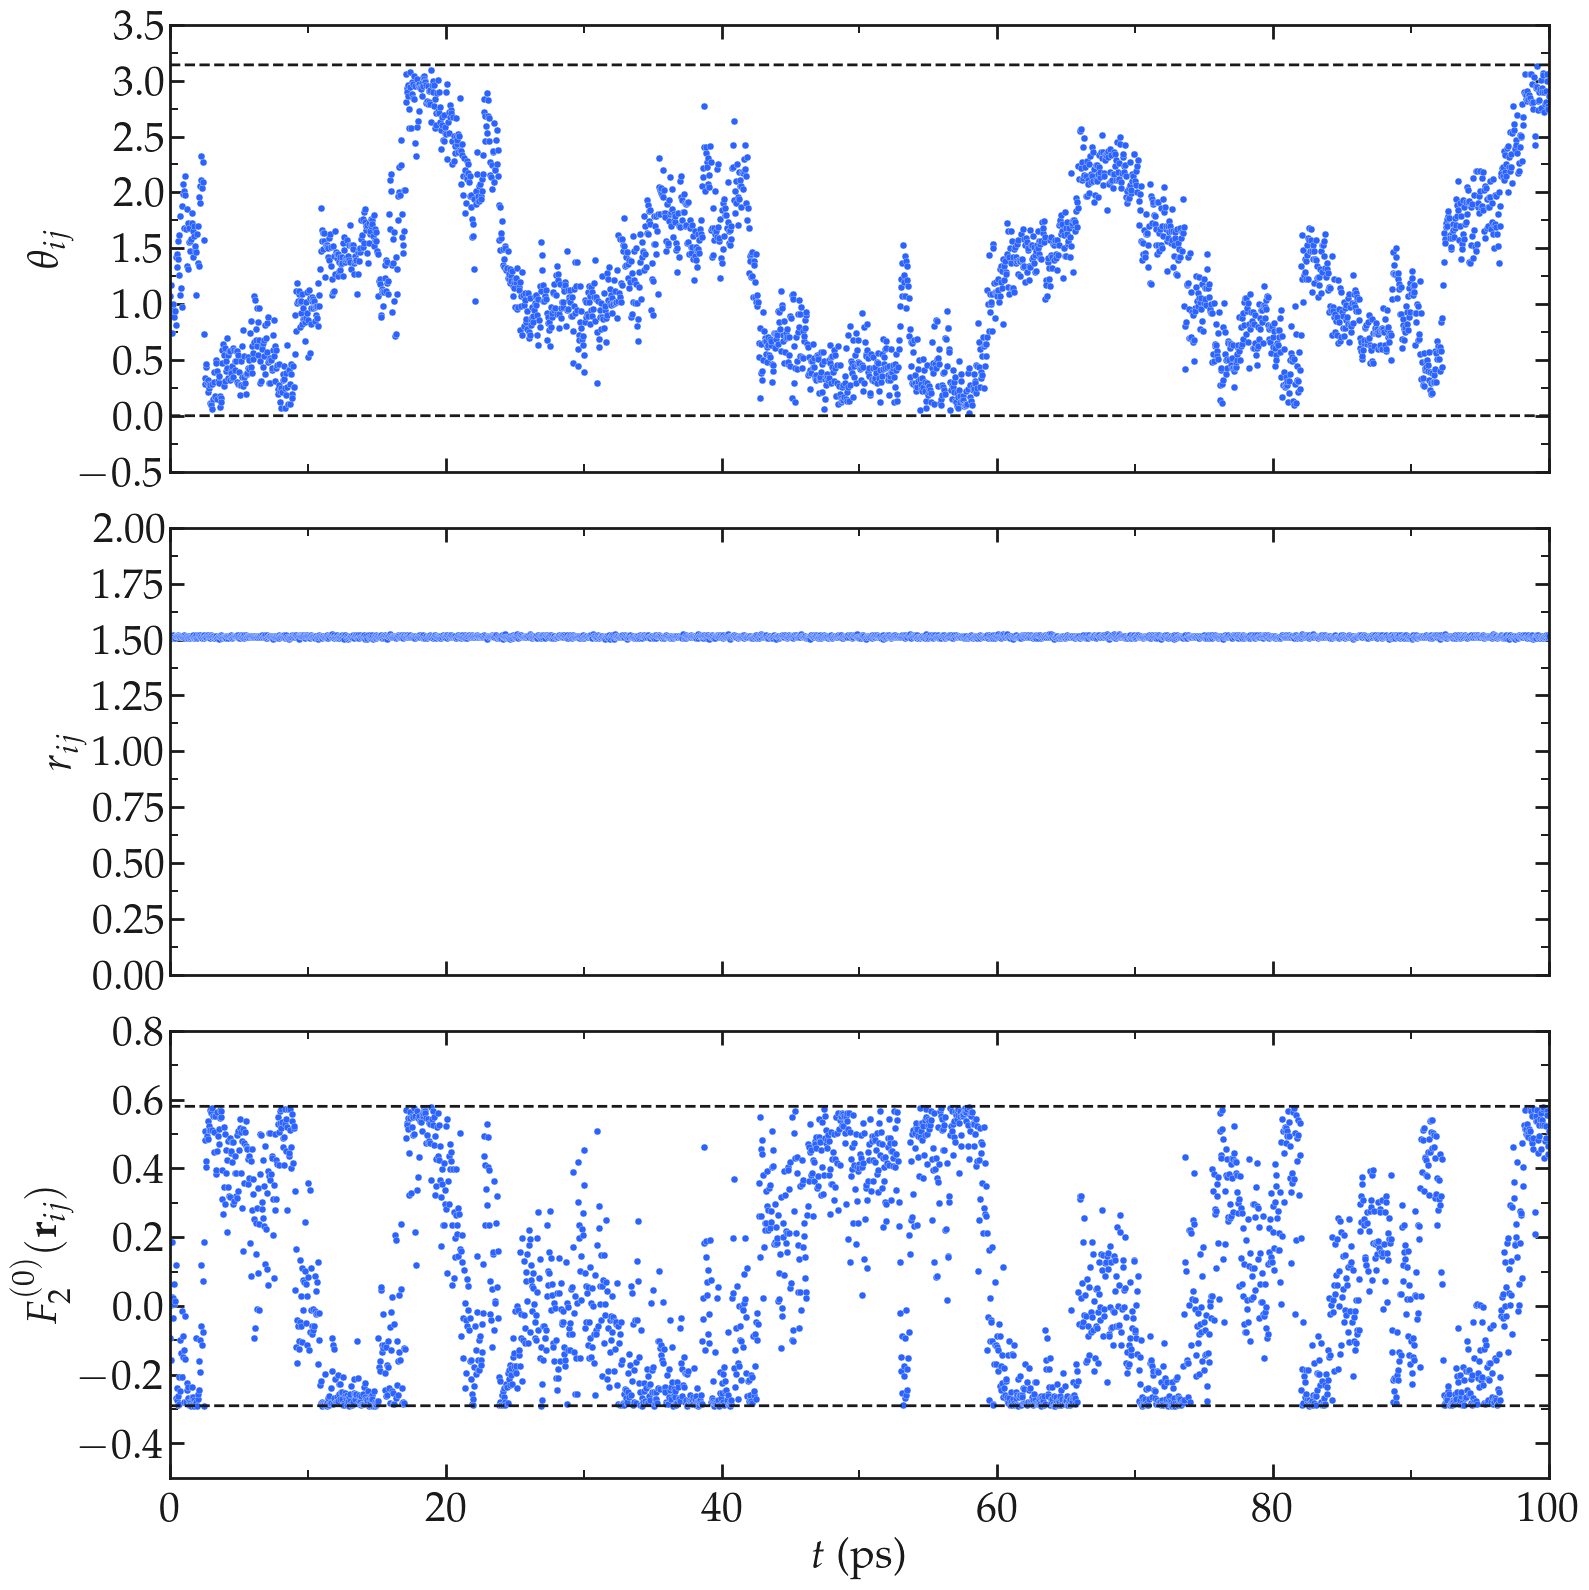

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


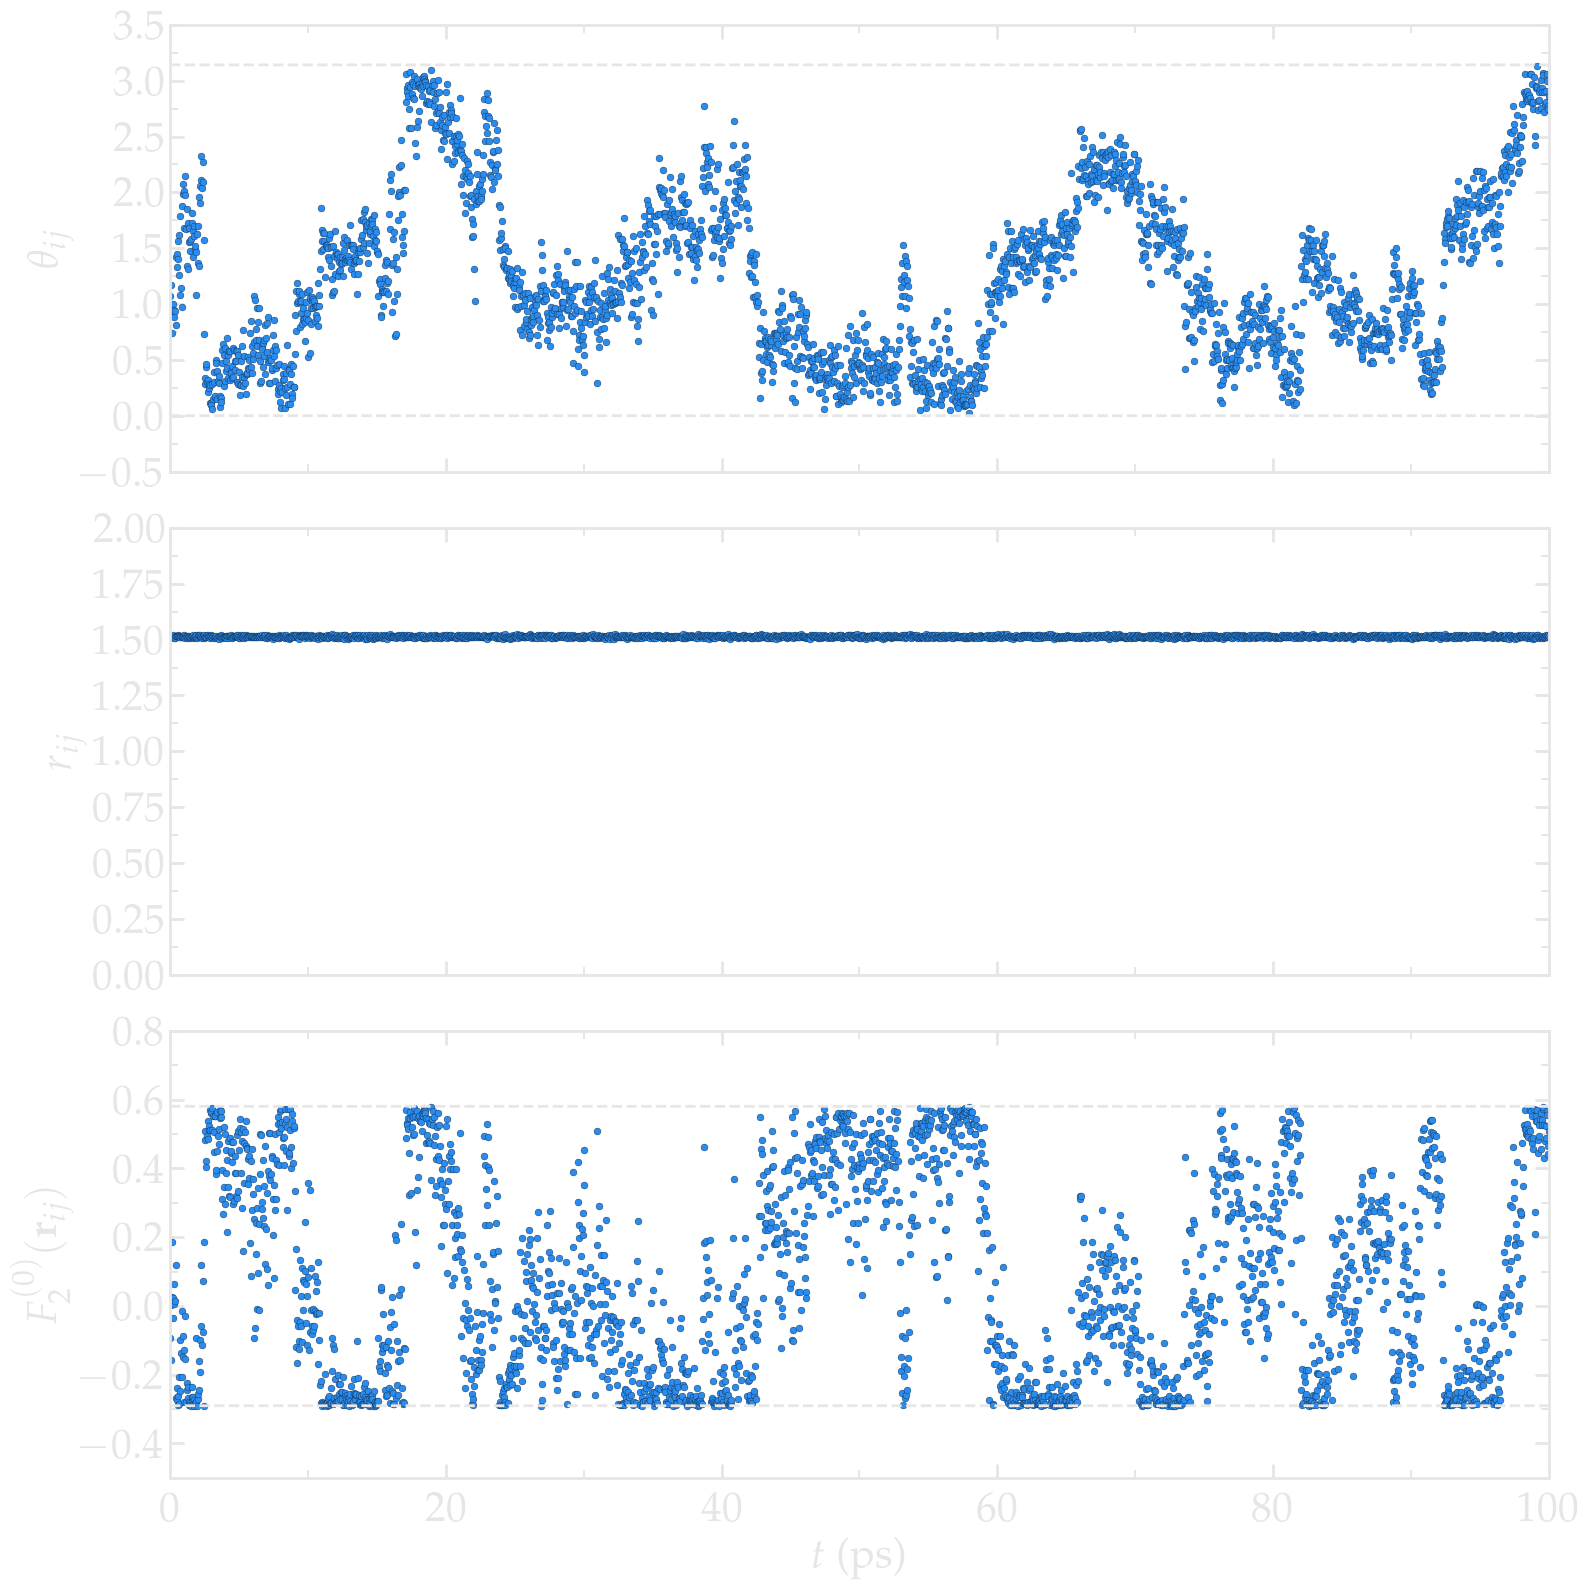

In [209]:
a = 1.51
# T1 bulk water
for mode, mygray, edge, myblue in zip(['light', 'dark'], [lightgray, darkgray], [black, white], [myblue_light, myblue_dark]):
    fig = plt.figure(figsize=(16, 16))

    ax1 = fig.add_subplot(311)
    ax1.plot(data_intramolecular[0], data_intramolecular[3], 'o', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=myblue)
    ax1.plot(data_intramolecular[0], data_intramolecular[3]*0, '--', linewidth = 2, color=mygray)
    ax1.plot(data_intramolecular[0], data_intramolecular[3]*0 + np.pi, '--', linewidth = 2, color=mygray)
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=None, ylabel=r'$\theta_{ij}$',
                       xlim=(0, 100), ylim=(-0.5, 3.5), cut_x=2, cut_y=2)

    ax1 = fig.add_subplot(312)
    ax1.plot(data_intramolecular[0], data_intramolecular[2], 'o', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=myblue)
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=None, ylabel=r'$r_{ij}$',
                       xlim=(0, 100), ylim=(0, 2), cut_x=2, cut_y=2)

    ax1 = fig.add_subplot(313)
    ax1.plot(data_intramolecular[0], data_intramolecular[1], 'o', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=myblue)
    ax1.plot(data_intramolecular[0], data_intramolecular[3]*0 + (3 * np.cos(0)**2 - 1) / a**3, '--', linewidth = 2, color=mygray)
    ax1.plot(data_intramolecular[0], data_intramolecular[3]*0 + (3 * np.cos(np.pi/2)**2 - 1) / a**3, '--', linewidth = 2, color=mygray)
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r"$t$ (ps)", ylabel=r'$F_2^{(0)} (\textbf{r}_{ij})$',
                       xlim=(0, 100), ylim=(-0.5, 0.8), cut_x=2, cut_y=2)
    save_figure(plt, fig, mode, name='best-practices/intramolecular-signal-illustration', save=True)

In [210]:

# Path to data
datapath_300 = "../../raw-data/bulk-water/N3000-medium-T300/"
datapath_275 = "../../raw-data/bulk-water/N3000-medium-T275/"
msize = 15
# cut-off for frequency and time
f_max = 3e5
t_max = 2e3

In [211]:
datapath = datapath_300
if recalculate:
    u = mda.Universe(datapath+"run.tpr", datapath+"run.xtc")
    group_i = u.select_atoms("type HW")
    nmr = nmrmd.NMR(u, group_i, number_i=600, isotropic=True, type_analysis="intra_molecular") # 1 hour - 2 hours
    t, gij_intra_300 = nmr.t[nmr.t < t_max], nmr.gij[0][nmr.t < t_max]
    f, J_intra_300 = nmr.f[nmr.f < f_max], nmr.J[0][nmr.f < f_max]
    f, R1_intra_300 = nmr.f[nmr.f < f_max], nmr.R1[nmr.f < f_max]
    nmr = nmrmd.NMR(u, group_i, number_i=20, isotropic=True, type_analysis="inter_molecular") # 1 hour - 2 hours
    t, gij_inter_300 = nmr.t[nmr.t < t_max], nmr.gij[0][nmr.t < t_max]
    f, J_inter_300 = nmr.f[nmr.f < f_max], nmr.J[0][nmr.f < f_max]
    f, R1_inter_300 = nmr.f[nmr.f < f_max], nmr.R1[nmr.f < f_max]
    np.savetxt("../../treated-data/best-practice/bulk-water/gij-illustration-300.dat", np.vstack([t, gij_intra_300, gij_inter_300]).T)
    np.savetxt("../../treated-data/best-practice/bulk-water/J-illustration-300.dat", np.vstack([f, J_intra_300, J_inter_300]).T)
    np.savetxt("../../treated-data/best-practice/bulk-water/R1-illustration-300.dat", np.vstack([f, R1_intra_300, R1_inter_300]).T)
else:
    t, gij_intra_300, gij_inter_300 = np.loadtxt("../../treated-data/best-practice/bulk-water/gij-illustration-300.dat").T
    f, J_intra_300, J_inter_300 = np.loadtxt("../../treated-data/best-practice/bulk-water/J-illustration-300.dat").T
    f, R1_intra_300, R1_inter_300 = np.loadtxt("../../treated-data/best-practice/bulk-water/R1-illustration-300.dat").T
datapath = datapath_275
if recalculate:
    u = mda.Universe(datapath+"run.tpr", datapath+"run.xtc")
    group_i = u.select_atoms("type HW")
    nmr = nmrmd.NMR(u, group_i, number_i=600, isotropic=True, type_analysis="intra_molecular") # 1 hour - 2 hours
    t, gij_intra_275 = nmr.t[nmr.t < t_max], nmr.gij[0][nmr.t < t_max]
    f, J_intra_275 = nmr.f[nmr.f < f_max], nmr.J[0][nmr.f < f_max]
    f, R1_intra_275 = nmr.f[nmr.f < f_max], nmr.R1[nmr.f < f_max]
    nmr = nmrmd.NMR(u, group_i, number_i=20, isotropic=True, type_analysis="inter_molecular") # 1 hour - 2 hours
    t, gij_inter_275 = nmr.t[nmr.t < t_max], nmr.gij[0][nmr.t < t_max]
    f, J_inter_275 = nmr.f[nmr.f < f_max], nmr.J[0][nmr.f < f_max]
    f, R1_inter_275 = nmr.f[nmr.f < f_max], nmr.R1[nmr.f < f_max]
    np.savetxt("../../treated-data/best-practice/bulk-water/gij-illustration-275.dat", np.vstack([t, gij_intra_275, gij_inter_275]).T)
    np.savetxt("../../treated-data/best-practice/bulk-water/J-illustration-275.dat", np.vstack([f, J_intra_275, J_inter_275]).T)
    np.savetxt("../../treated-data/best-practice/bulk-water/R1-illustration-275.dat", np.vstack([f, R1_intra_275, R1_inter_275]).T)
else:
    t, gij_intra_275, gij_inter_275 = np.loadtxt("../../treated-data/best-practice/bulk-water/gij-illustration-275.dat").T
    f, J_intra_275, J_inter_275 = np.loadtxt("../../treated-data/best-practice/bulk-water/J-illustration-275.dat").T
    f, R1_intra_275, R1_inter_275 = np.loadtxt("../../treated-data/best-practice/bulk-water/R1-illustration-275.dat").T

In [249]:
from scipy.optimize import curve_fit
def correlation1(x, a, b):
    # b is tau_c
    return a * np.exp(-x/b)
def power_law(x, a):
    return a / x**1.5
def spectrum1(x, a, b):
    # a = 2 G(0) tau_c
    return a/(1+(x*b)**2) 

tau_intra_275 = 6.34 ps
tau_intra_300 = 3.13 ps
tau_inter_275 = 8.21 ps
tau_inter_300 = 4.6 ps


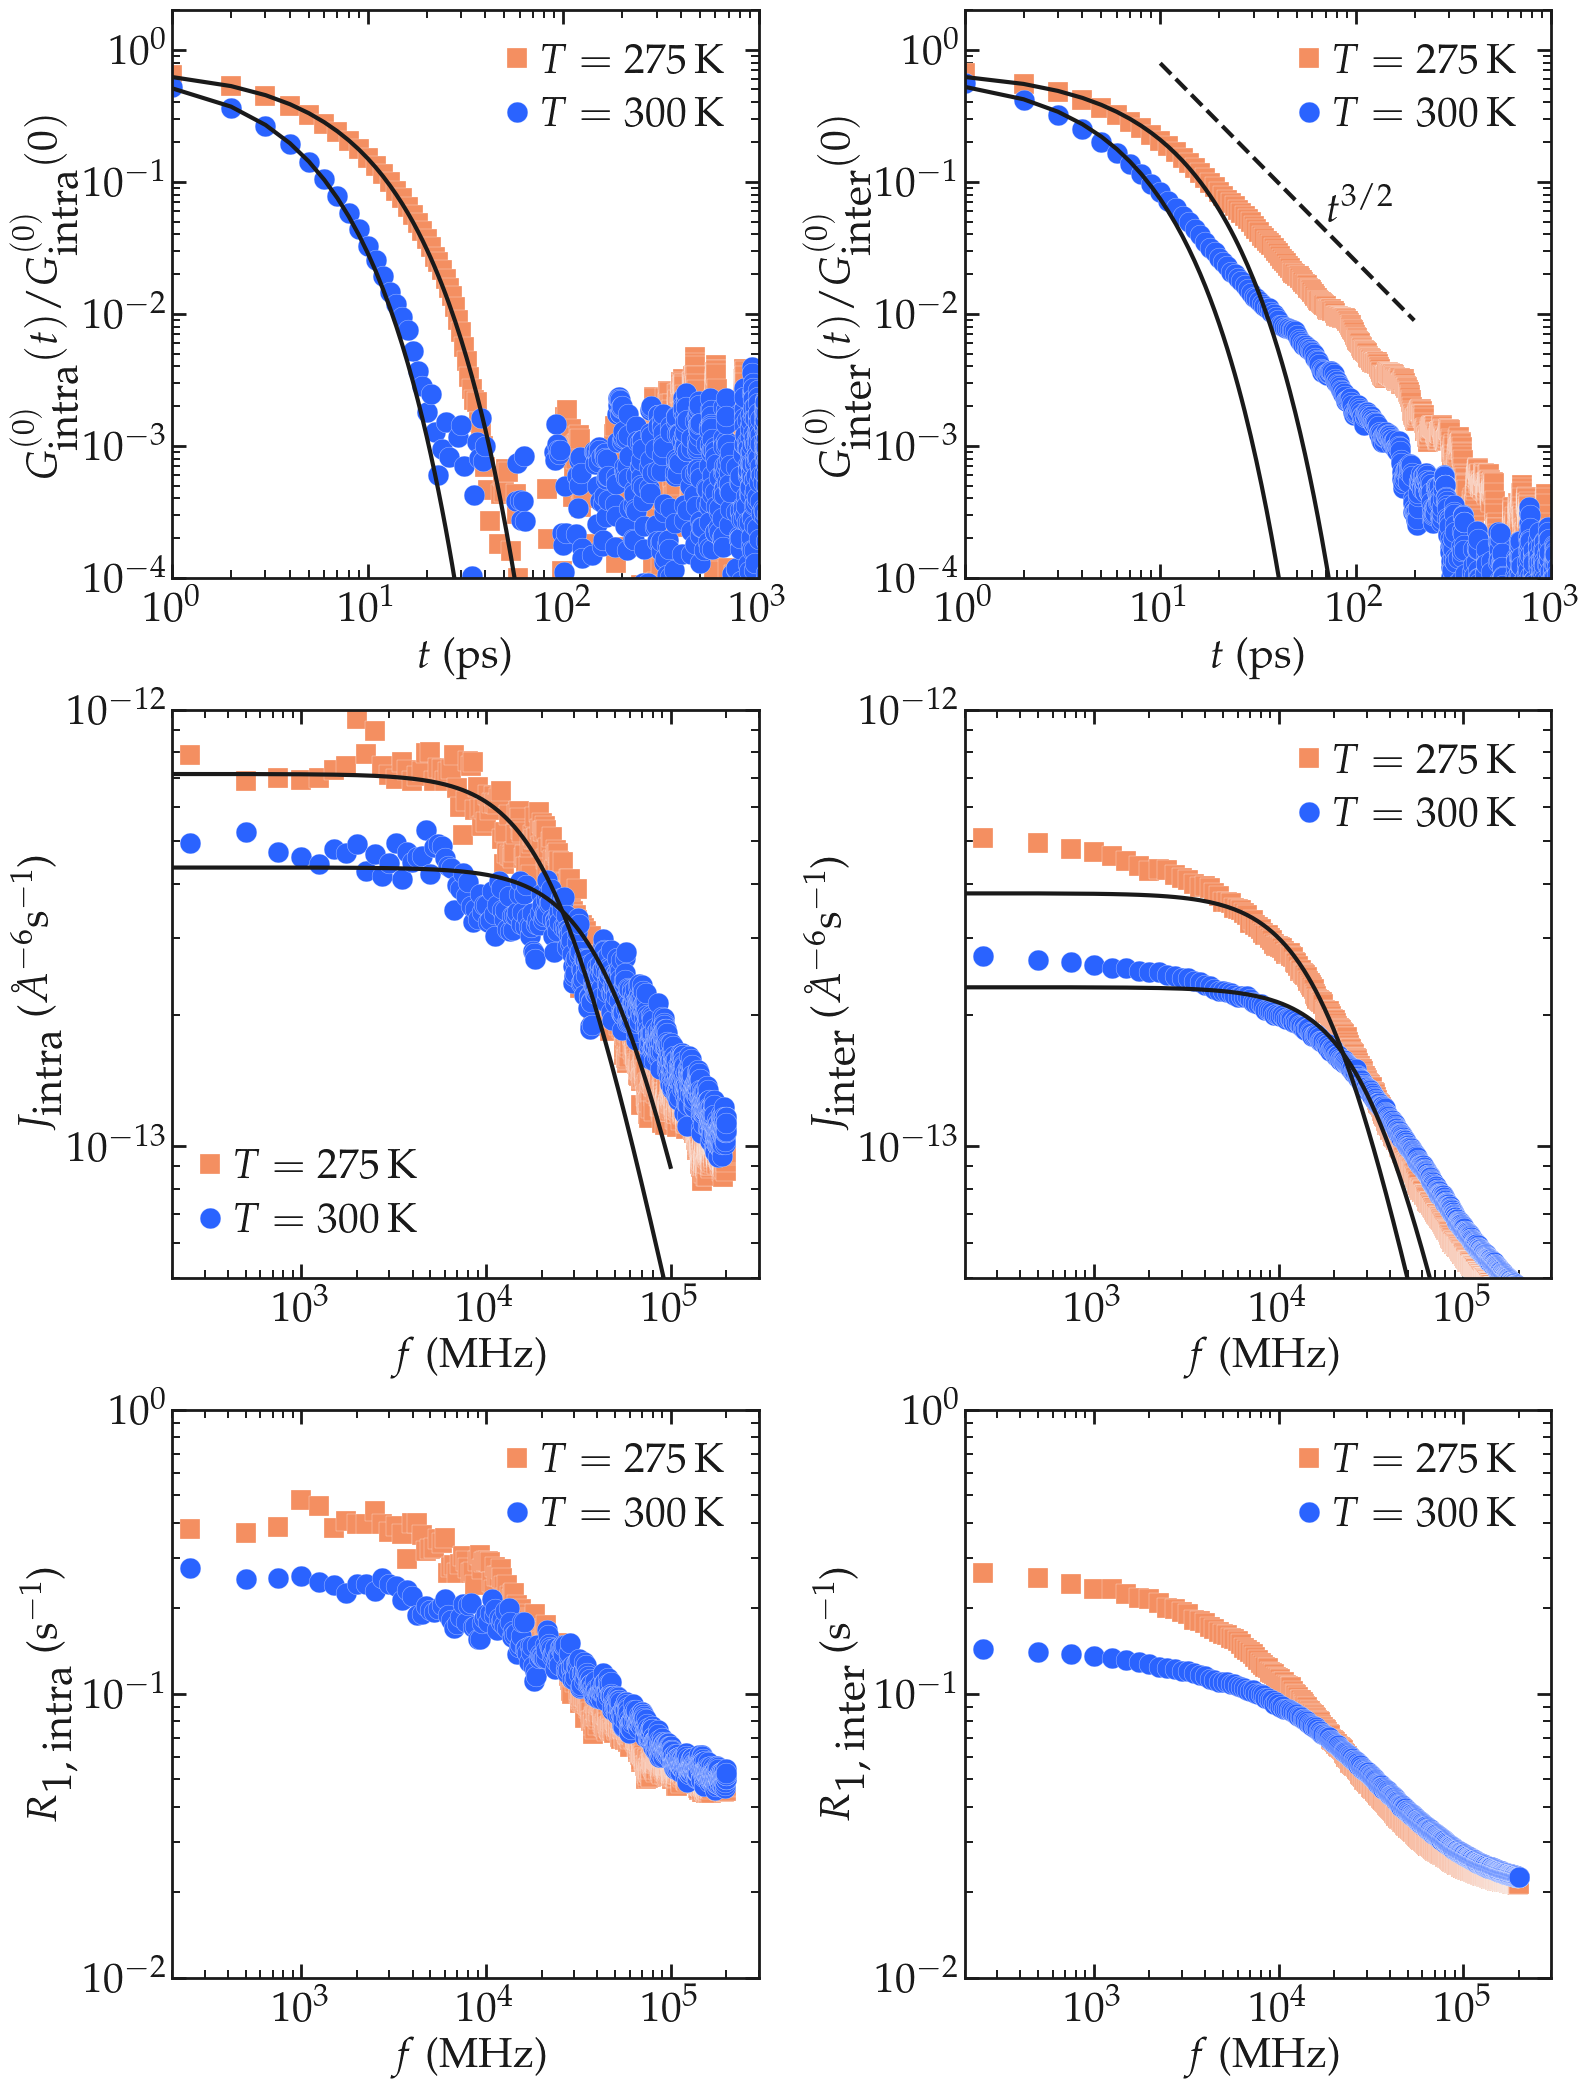

tau_intra_275 = 6.34 ps
tau_intra_300 = 3.13 ps
tau_inter_275 = 8.21 ps
tau_inter_300 = 4.6 ps


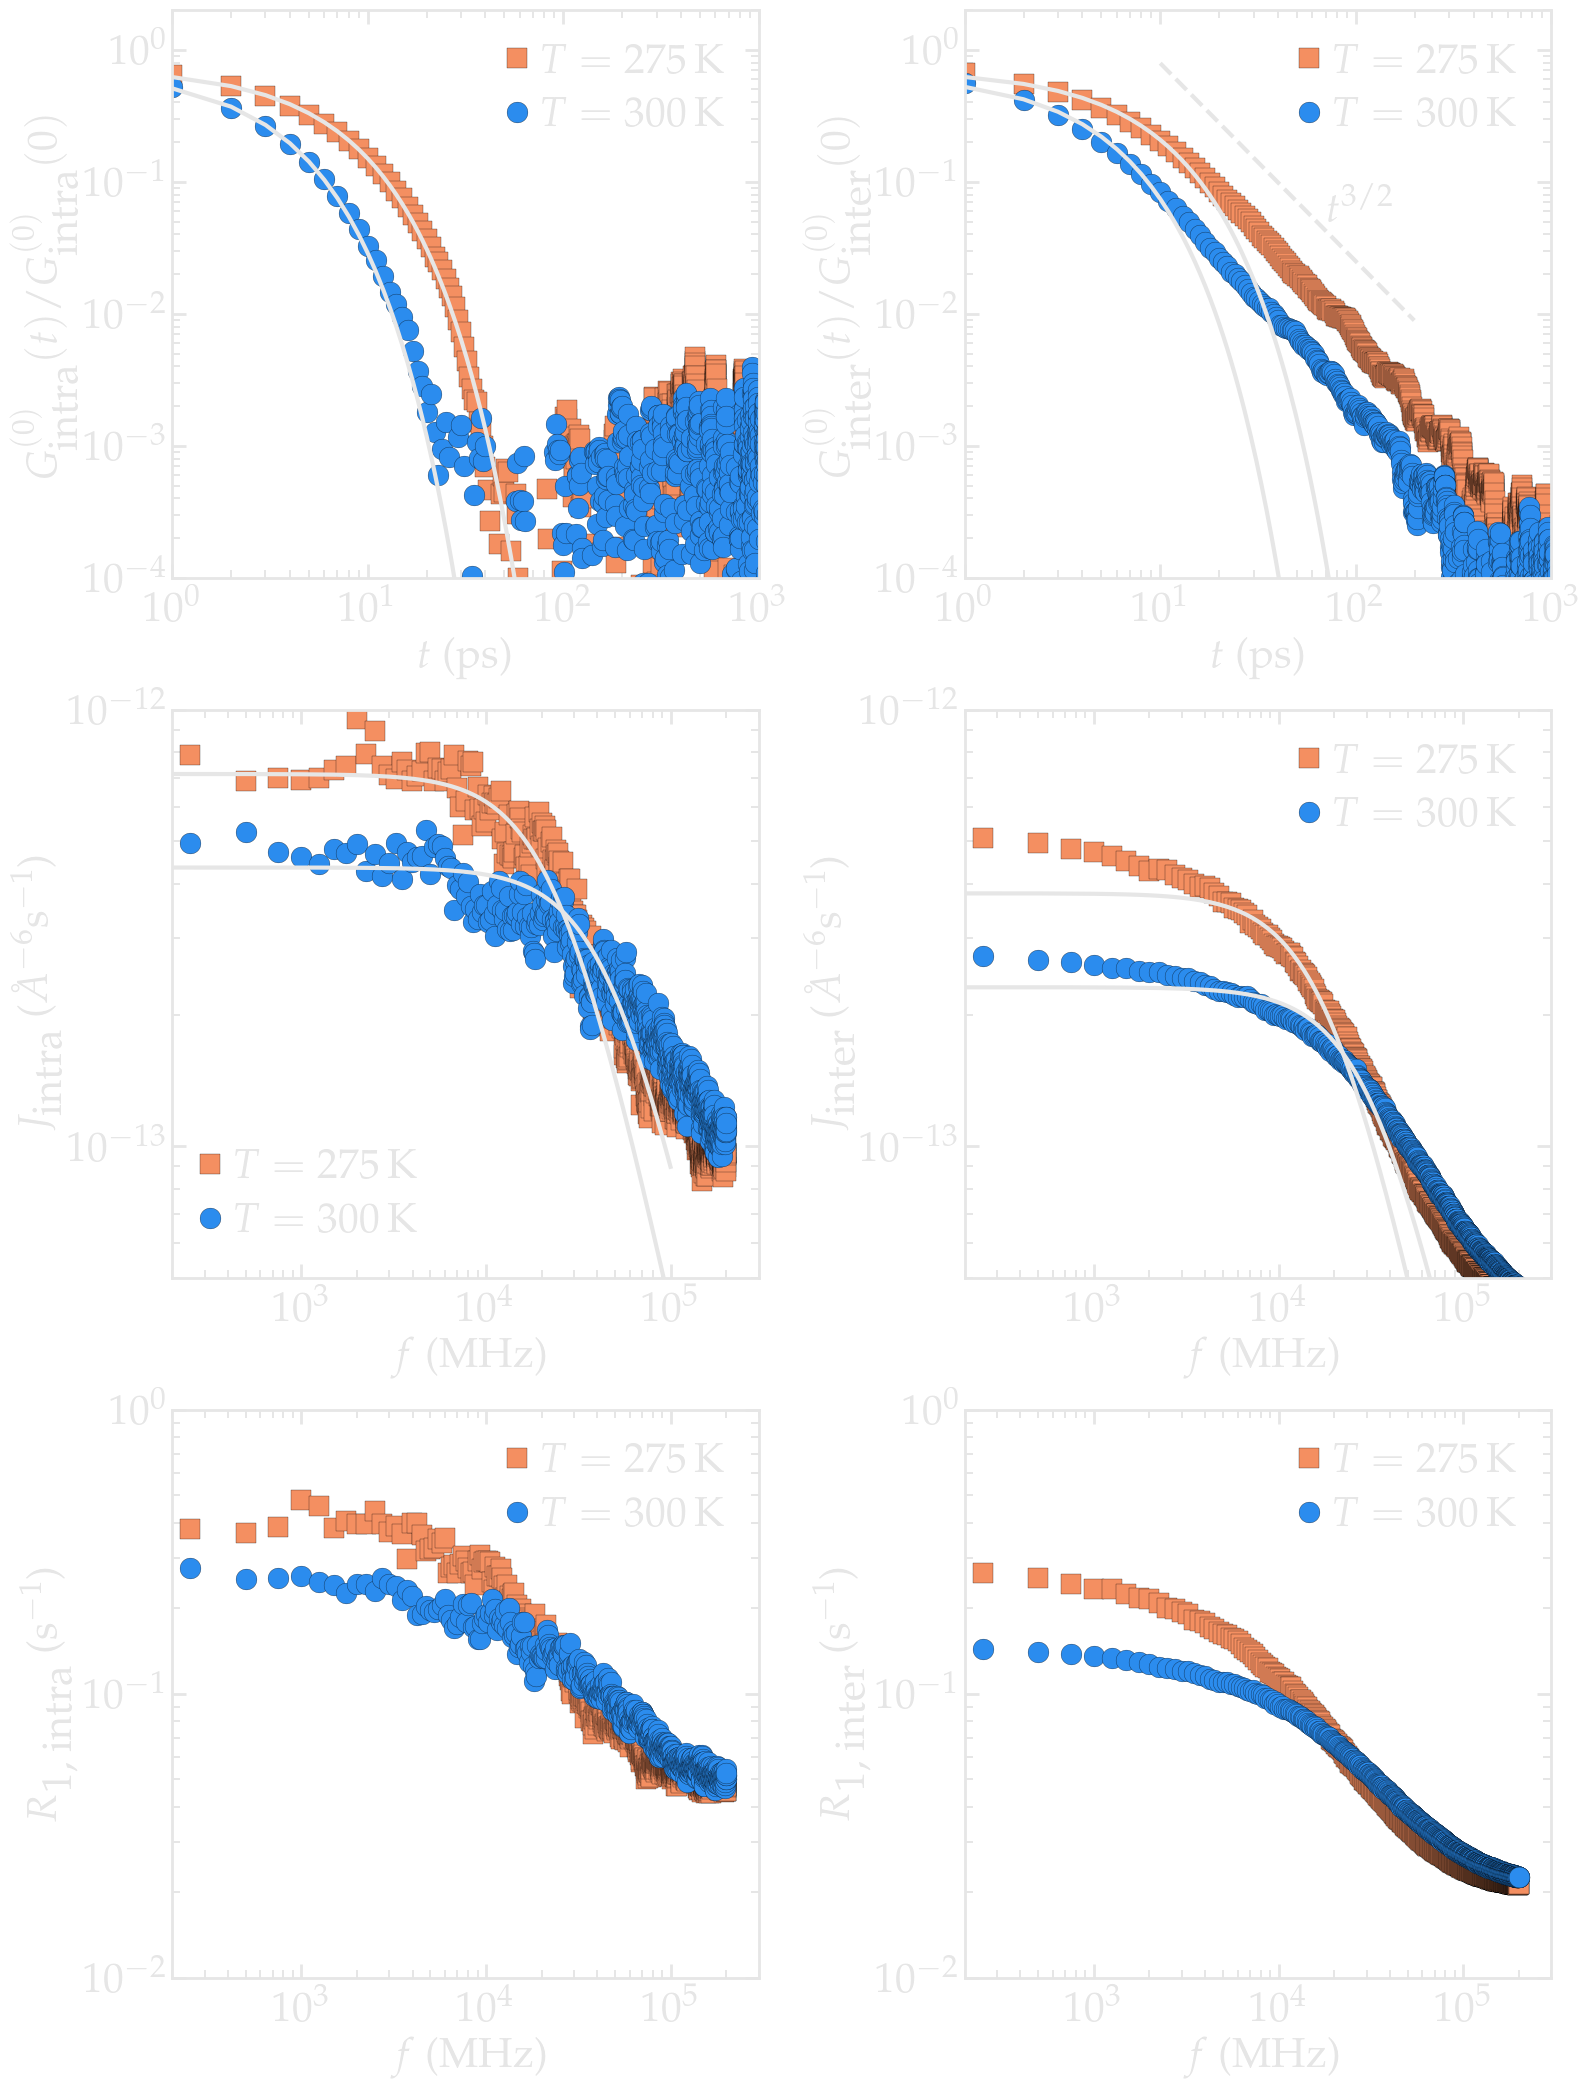

In [294]:
# Correlation function
for mode, mygray, edge, myblue in zip(['light', 'dark'], [lightgray, darkgray], [black, white], [myblue_light, myblue_dark]):
    fig = plt.figure(figsize=(16, 21))
    ax1 = fig.add_subplot(321)
    ax1.loglog(t, gij_intra_275/gij_intra_275[0], 's', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=myred, label=r'$T = 275$\,K')
    ax1.loglog(t, gij_intra_300/gij_intra_300[0], 'o', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=myblue, label=r'$T = 300$\,K')
    # Fitting
    popt, pcov = curve_fit(correlation1, t[1:20], gij_intra_275[1:20]/gij_intra_275[0])
    ax1.loglog(t, correlation1(t, *popt), '-', linewidth=3, color=mygray)
    tau_intra_275 = popt[1]
    print("tau_intra_275 =",np.round(tau_intra_275,2),"ps")
    popt, pcov = curve_fit(correlation1, t[1:20], gij_intra_300[1:20]/gij_intra_300[0])
    ax1.loglog(t, correlation1(t, *popt), '-', linewidth=3, color=mygray)
    tau_intra_300 = popt[1]
    print("tau_intra_300 =",np.round(tau_intra_300,2),"ps")
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r"$t$ (ps)", ylabel=r'$G^{(0)}_\textrm{intra} (t) / G^{(0)}_\textrm{intra} (0)$',
                       xlim=(1, 1000), ylim=(0.0001, 2))
    ax1 = fig.add_subplot(322)
    ax1.loglog(t, gij_inter_275/gij_inter_275[0], 's', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=myred, label=r'$T = 275$\,K')
    ax1.loglog(t, gij_inter_300/gij_inter_300[0], 'o', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=myblue, label=r'$T = 300$\,K')
    # Fitting
    popt, pcov = curve_fit(correlation1, t[1:20], gij_inter_275[1:20]/gij_inter_275[0])
    ax1.loglog(t, correlation1(t, *popt), '-', linewidth=3, color=mygray)
    tau_inter_275 = popt[1]
    print("tau_inter_275 =",np.round(tau_inter_275,2),"ps")
    popt, pcov = curve_fit(correlation1, t[1:20], gij_inter_300[1:20]/gij_inter_300[0])
    ax1.loglog(t, correlation1(t, *popt), '-', linewidth=3, color=mygray)
    tau_inter_300 = popt[1]
    print("tau_inter_300 =",np.round(tau_inter_300,2),"ps")
    ax1.loglog(t[10:200], power_law(t[10:200], 25), '--', linewidth=3, color=mygray)
    ax1.text(71, 0.05, r'$t^{3/2}$', fontsize = fontsize, color = mygray)
    tau = popt[1]
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r"$t$ (ps)", ylabel=r'$G^{(0)}_\textrm{inter} (t) / G^{(0)}_\textrm{inter} (0)$',
                       xlim=(1, 1000), ylim=(0.0001, 2))
    ax1 = fig.add_subplot(323)
    ax1.loglog(f[f<=2e5], J_intra_275[f<=2e5], 's', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=myred, label=r'$T = 275$\,K')
    ax1.loglog(f[f<=2e5], J_intra_300[f<=2e5], 'o', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=myblue, label=r'$T = 300$\,K')
    # Fitting
    ax1.loglog(f[:400], spectrum1(f[:400], np.mean(J_intra_275[:400][:40]), tau_intra_275*2*np.pi/1e6), '-', linewidth=3, color=mygray)
    ax1.loglog(f[:400], spectrum1(f[:400], np.mean(J_intra_300[:400][:40]), tau_intra_300*2*np.pi/1e6), '-', linewidth=3, color=mygray)
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r"$f$ (MHz)", ylabel=r'$J_\textrm{intra}$ ($\AA^{-6}$s$^{-1}$)',
                       xlim=(2e2, 3e5), ylim=(5e-14, 1e-12))
    ax1 = fig.add_subplot(324)
    ax1.loglog(f[f<=2e5], J_inter_275[f<=2e5], 's', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=myred, label=r'$T = 275$\,K')
    ax1.loglog(f[f<=2e5], J_inter_300[f<=2e5], 'o', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=myblue, label=r'$T = 300$\,K')
    
    ax1.loglog(f[:400], spectrum1(f[:400], np.mean(J_inter_275[:400][:40]), tau_inter_275*2*np.pi/1e6), '-', linewidth=3, color=mygray)
    ax1.loglog(f[:400], spectrum1(f[:400], np.mean(J_inter_300[:400][:40]), tau_inter_300*2*np.pi/1e6), '-', linewidth=3, color=mygray)
    
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r"$f$ (MHz)", ylabel=r'$J_\textrm{inter}$ ($\AA^{-6}$s$^{-1}$)',
                       xlim=(2e2, 3e5), ylim=(5e-14, 1e-12))
    ax1 = fig.add_subplot(325)
    ax1.loglog(f[f<=2e5], R1_intra_275[f<=2e5], 's', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=myred, label=r'$T = 275$\,K')
    ax1.loglog(f[f<=2e5], R1_intra_300[f<=2e5], 'o', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=myblue, label=r'$T = 300$\,K')
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r"$f$ (MHz)", ylabel=r'$R_\textrm{1, intra}$ (s$^{-1}$)',
                       xlim=(2e2, 3e5), ylim=(0.01, 1))
    ax1 = fig.add_subplot(326)
    ax1.loglog(f[f<=2e5], R1_inter_275[f<=2e5], 's', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=myred, label=r'$T = 275$\,K')
    ax1.loglog(f[f<=2e5], R1_inter_300[f<=2e5], 'o', markersize=msize, markeredgecolor=edge, markeredgewidth=0.2, color=myblue, label=r'$T = 300$\,K')
    figure_improvement(ax1, mygray, font, fontsize,
                       xlabel=r"$f$ (MHz)", ylabel=r'$R_\textrm{1, inter}$ (s$^{-1}$)',
                       xlim=(2e2, 3e5), ylim=(0.01, 1))
    save_figure(plt, fig, mode, name='best-practices/gij-R1-illustration', save=True)